In [8]:
from src.files.blast import BLASTJsonFile
from src.files.fasta import FASTAFile, get_reverse_complement
import re
import os 
import pandas as pd 
from tqdm import tqdm
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 
from src.download import *
from utils import * 
from src.stop_codon import *
from src.data import get_arf1_data

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
genome_metadata_df = pd.read_csv('../data/methanosarcinales_ncbi_metadata.tsv', sep='\t')
genome_metadata_df = genome_metadata_df.drop_duplicates('Assembly Name')

genome_ids = genome_metadata_df['Assembly Accession'].values
# download_genomes(genome_ids)
# extract_genomes()
downloaded_genome_ids = [os.path.basename(path).replace('.fn', '') for path in os.listdir('../data/ncbi/genomes')]
genome_ids = np.intersect1d(genome_ids, downloaded_genome_ids).tolist()
genome_ids.remove('GCA_050259915.1') # GCA_050259915.1.fn fails because there are not enough nucleotides for Prodigal.

In [10]:
if not os.path.exists('../data/arf1-2_hmmer.csv'):
    # Only ran the HMM for aRF-1 on these genomes. 
    hmmer_df = hmmer_load(genome_ids=genome_ids, query_names=['aRF1_eRF1'])
    hmmer_df.to_csv('../data/arf1-2_hmmer.csv')

hmmer_df = pd.read_csv('../data/arf1-2_hmmer.csv', index_col=0)
genome_ids = np.intersect1d(genome_ids, hmmer_df.genome_id.unique()) # Remove the genome IDs which had empty HMM output files.

hits_per_genome_id = hmmer_df.genome_id.value_counts()
hits_per_genome_id = hits_per_genome_id[hits_per_genome_id > 1].copy()

print('Num. genomes with at least one aRF1 hit:', len(genome_ids))
print('Num. genomes with at least two aRF1 hits:', len(hits_per_genome_id))

# Want to grab the top two best hits per genome. 
# hmmer_df = hmmer_df.sort_values('e_value')
# hmmer_df = hmmer_df[hmmer_df.groupby('genome_id').cumcount() < 2].copy()

Num. genomes with at least one aRF1 hit: 1202
Num. genomes with at least two aRF1 hits: 1100


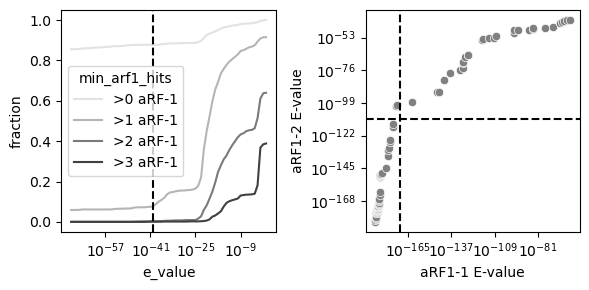

In [11]:

MAX_E_VALUE = 1e-40
ARF1_MAX_E_VALUE = 1e-170
ARF12_MAX_E_VALUE = 1e-110

def figure(hmmer_df:pd.DataFrame):
    fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(6, 3))

    e_values = [1 / (10**n) for n in range(70)]
    n_genomes = hmmer_df.genome_id.nunique() # How many genome IDs have any aRF-1 hit?

    figure_df = list()
    for min_arf1_hits in range(4):
        for e_value in e_values:
            arf1_hits_per_genome = hmmer_df[hmmer_df.e_value < e_value].genome_id.value_counts()
            n = (arf1_hits_per_genome > min_arf1_hits).sum() # Get the number of genomes with more than min_arf1_hits aRF-1 hits.
            figure_df.append({'e_value':e_value, 'fraction':n/n_genomes, 'min_arf1_hits':f'>{min_arf1_hits} aRF-1'})
    figure_df = pd.DataFrame(figure_df)

    sns.lineplot(figure_df, x='e_value', y='fraction', hue='min_arf1_hits', palette='Grays', ax=ax_a, legend=True)
    ax_a.set_xscale('log')
    ax_a.set_xscale('log')
    ax_a.axvline(MAX_E_VALUE, ls='--', color='black')

    figure_df = hmmer_df[hmmer_df.e_value < MAX_E_VALUE].copy()
    figure_df = figure_df.sort_values('e_value')
    figure_df['arf1_type'] = figure_df.groupby('genome_id').cumcount() + 1

    hits_per_genome_id = figure_df.groupby('genome_id').size() 
    genome_ids_with_multiple_arfs = hits_per_genome_id[hits_per_genome_id > 1].index.values 
    figure_df = figure_df[figure_df.genome_id.isin(genome_ids_with_multiple_arfs)]
    figure_df = figure_df[figure_df.arf1_type <= 2].copy() # Get the first two best hits per genome. 
    
    x, y = figure_df[figure_df.arf1_type == 1].e_value.values, figure_df[figure_df.arf1_type == 2].e_value.values
    sns.scatterplot(ax=ax_b, x=x, y=y, color='gray')
    ax_b.set_yscale('log')
    ax_b.set_xscale('log')
    ax_b.axvline(ARF1_MAX_E_VALUE, ls='--', color='black')
    ax_b.axhline(ARF12_MAX_E_VALUE, ls='--', color='black')
    ax_b.set_xlabel('aRF1-1 E-value')
    ax_b.set_ylabel('aRF1-2 E-value')

    fig.tight_layout()
    plt.show()

    mask = ((figure_df.arf1_type == 1) & (figure_df.e_value < ARF1_MAX_E_VALUE)) | ((figure_df.arf1_type == 2) & (figure_df.e_value < ARF12_MAX_E_VALUE))
    figure_df = figure_df[mask].copy()
    hits_per_genome_id = figure_df.groupby('genome_id').size() 
    genome_ids_with_multiple_arfs = hits_per_genome_id[hits_per_genome_id > 1].index.values 
    figure_df = figure_df[figure_df.genome_id.isin(genome_ids_with_multiple_arfs)]

    return figure_df

cleaned_hmmer_df = figure(hmmer_df)


In [12]:
if not os.path.exists('../data/arf1-2_cleaned.csv'):
    cleaned_arf12_df = get_arf1_data(cleaned_hmmer_df, data_dir='../data/prodigal')
    cleaned_arf12_df = build_stop_codon_dataset(cleaned_arf12_df, fn_dir='../data/ncbi/genomes')

    stop_codon_metadata_df = pd.read_csv('../data/arf1-2_stop_codon_metadata.csv', index_col=0)
    stop_codon_metadata_df['tag_percent'] = stop_codon_metadata_df.TAG / stop_codon_metadata_df['total']
    
    cleaned_arf12_df['tag_percent'] = cleaned_arf12_df.genome_id.map(stop_codon_metadata_df.tag_percent)
    cleaned_arf12_df.to_csv('../data/arf1-2_cleaned.csv')

cleaned_arf12_df = pd.read_csv('../data/arf1-2_cleaned.csv', index_col=0)
cleaned_arf12_df['recoded'] = cleaned_arf12_df.tag_percent < 0.05


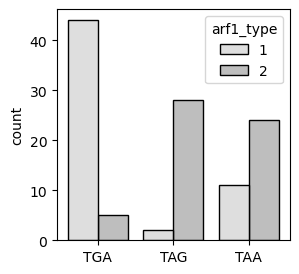

In [13]:
fig, ax = plt.subplots(figsize=(3, 3))

figure_df = cleaned_arf12_df.copy()
palette = {1:'lightgray', 2:'darkgray'}
sns.histplot(figure_df, ax=ax, x='stop_codon', hue='arf1_type', multiple='dodge', shrink=0.8, stat='count', common_norm=True, palette=palette)
# ax.set_xticks(ax.get_xticks(), labels=ax.get_xticklabels(), rotation=90)
ax.set_xlabel('')
ax.set_ylabel('count')
plt.show()

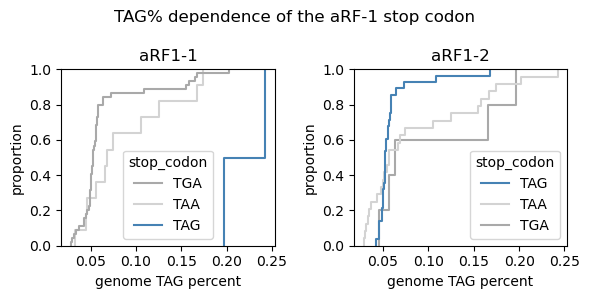

In [14]:
fig, (ax_a, ax_b) = plt.subplots(figsize=(6, 3), ncols=2)

figure_df = cleaned_arf12_df.copy()

palette = {'TAG':'steelblue', 'TAA':'lightgray', 'TGA':'darkgray'}
sns.ecdfplot(figure_df[figure_df.arf1_type == 1], ax=ax_a, hue='stop_codon', x='tag_percent', palette=palette)
sns.ecdfplot(figure_df[figure_df.arf1_type == 2], ax=ax_b, hue='stop_codon', x='tag_percent', palette=palette)

for ax in [ax_a, ax_b]:
    ax.set_ylabel('proportion')
    ax.set_xlabel('genome TAG percent')

ax_a.set_title('aRF1-1')
ax_b.set_title('aRF1-2')

fig.suptitle('TAG% dependence of the aRF-1 stop codon')
fig.tight_layout()
plt.show()